# **Introduction:**
- We chose a “bicycle rentals” dataset from Kaggle

- The data was collected from a bicycle sharing service:
A public service in which individuals are able to rent bicycles for short periods of time

- Given that bikes are rented from automated docking stations, reliable data is collected with every use – including location, duration of trip, time and date

- This data can be then cross-referenced with weather reports, city events and holidays

- In this project we will try to test whether the patterns of bike sharing, i.e. the amount of bikes being rented on an hourly basis, could be predicted using different parameters, such as:
Weather (season, temperature, humidity)
Time (year, month, day, hour)
Patterns and behaviour of the residents (working day, weekend or holiday)

Four regression models will be used:
- Multiple linear regression
- Generalized linear model (GLM) - with Poisson family and log link function
- Decision tree
- KNN

The measure of error across all models will be RMSE



**Importing Libraries:**

In [718]:
import pandas as pd
import numpy as np
import random as rnd

import seaborn as sns
import matplotlib.pyplot as plt
import pylab as pl

from sklearn.model_selection import train_test_split as split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error


**Importing the Kaggle dataset from Github:**

In [719]:
df = pd.read_csv('https://raw.githubusercontent.com/shaikara/Regression-project---Bike-sharing/main/hour.csv')


# **EDA Process:**

- The data contains 17,379 rows, each representing a single hour on a given day, starting 1.1.2011 and ending 31.12.2012

- There are no missing values in the data.

In [720]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


**The data contains 17 columns:**
- Index: instance number
- Potential Explanatory Variables:

  - Time related: Date,   Year,   Month,   Hour
  - Event related: Holiday,  Weekday, Working-day
  - Weather related: Season, Weather description, Temperature, Actual Temperature, Humidity, Windspeed 

- Potential Response Variables:
 Casual users +
Registered users
=
Total count





In [721]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


- The total count data is positive, right skewed
- The response variable is discrete


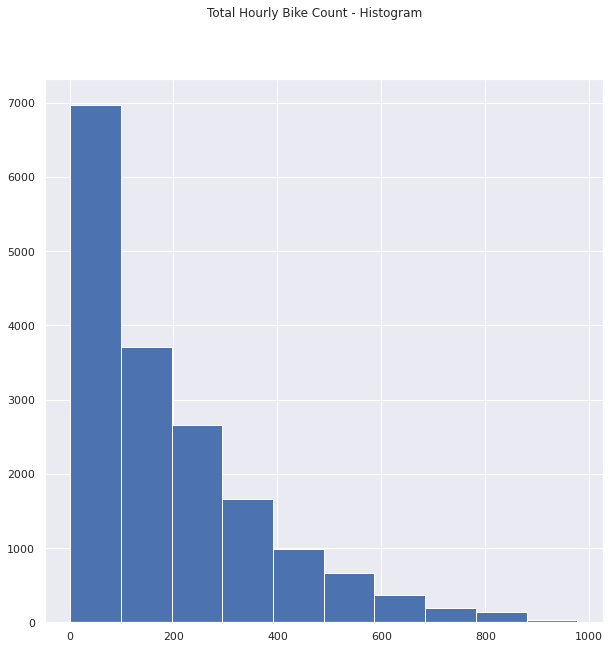

In [722]:
df.cnt.hist(figsize=(10,10),)
pl.suptitle("Total Hourly Bike Count - Histogram");


In [723]:
df.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


**Variables histograms:**

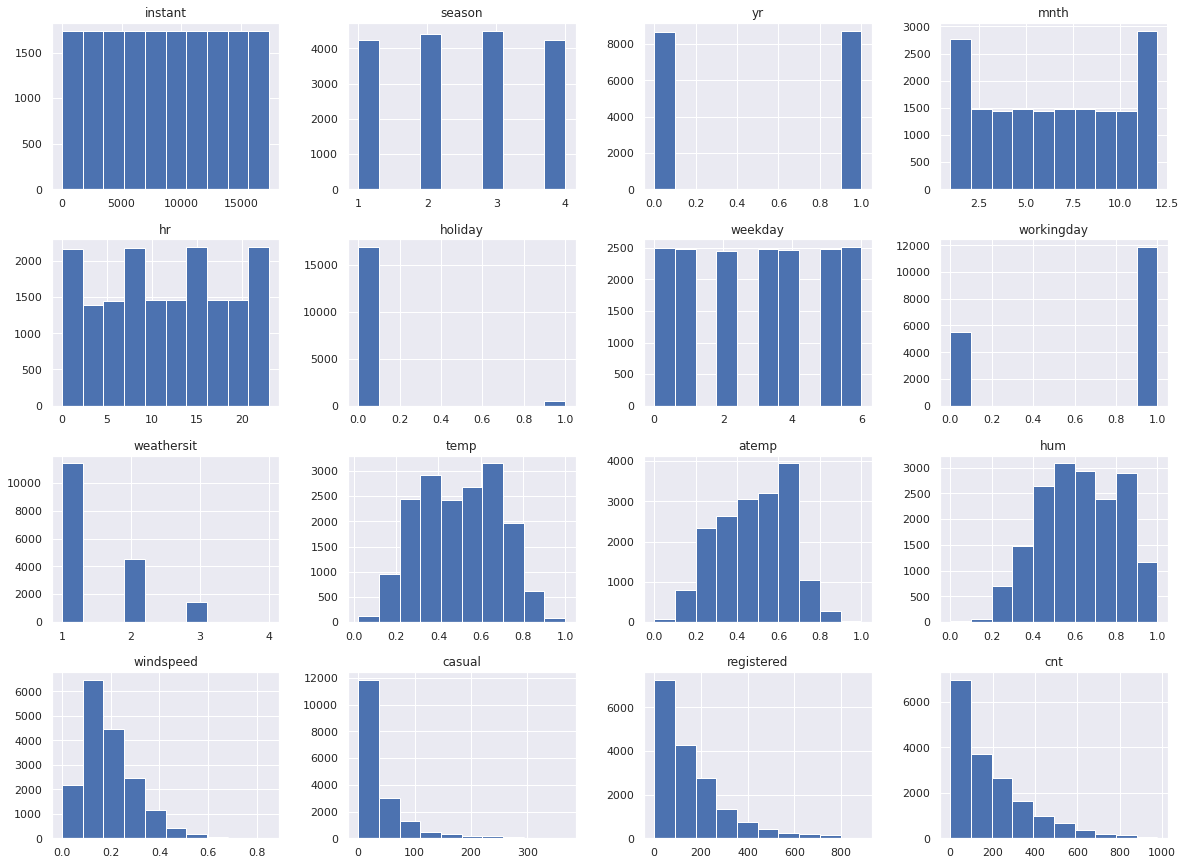

In [724]:
df.hist(figsize=(20,15));

By looking at paired scatterplots of the continuous variables it is possible to detect possible outliers:
- Decided to remove 22 zero-humidity observations and 24 temperature outliers – losing 0.26% of our data

Also a strong correlatin can be noted between the two measures of temperature - temp and a-temp





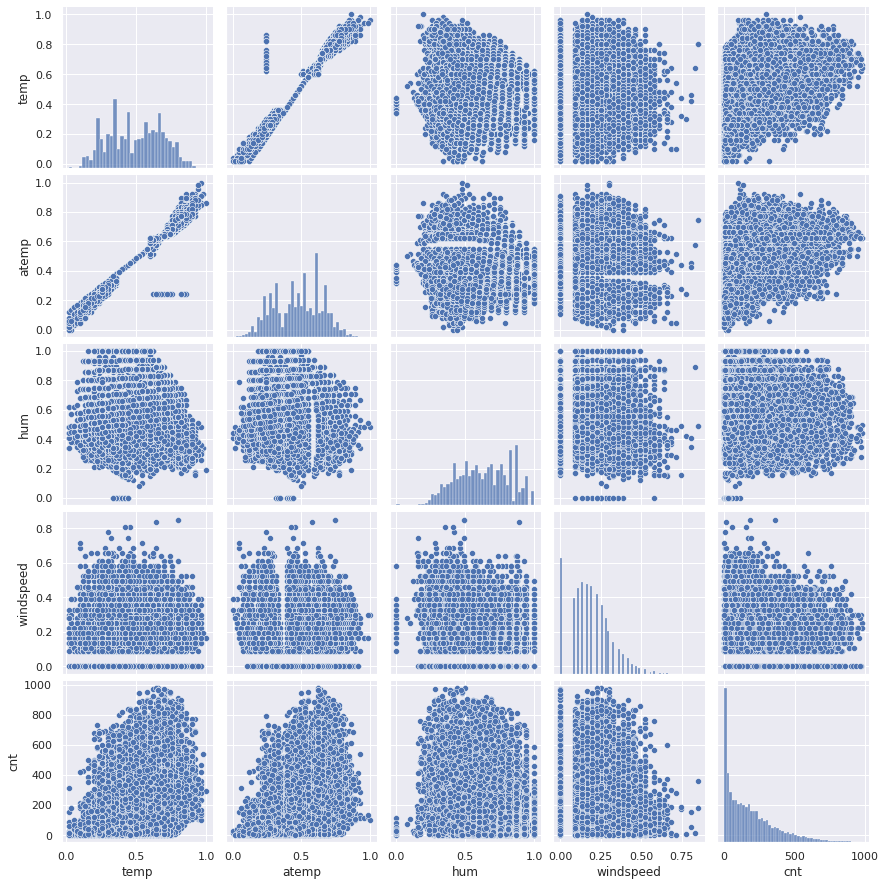

In [725]:
sns.pairplot(df[['temp', 'atemp', 'hum', 'windspeed', 'cnt']]);

Removing zero humidity observations:

In [726]:
(df['hum'] == 0).sum()

22

In [727]:
df = df[df.hum != 0]

Locating and removing temperature outliers:

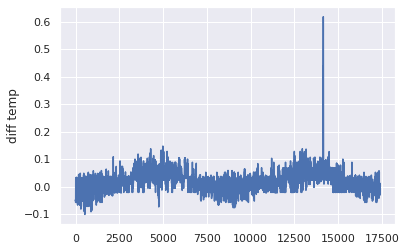

In [728]:
diff = df['temp']-df['atemp']
diff.plot(ylabel = 'diff temp');


By examining the response variable and spliting it into two components - casual users and registered users - we can detect different patterns for each

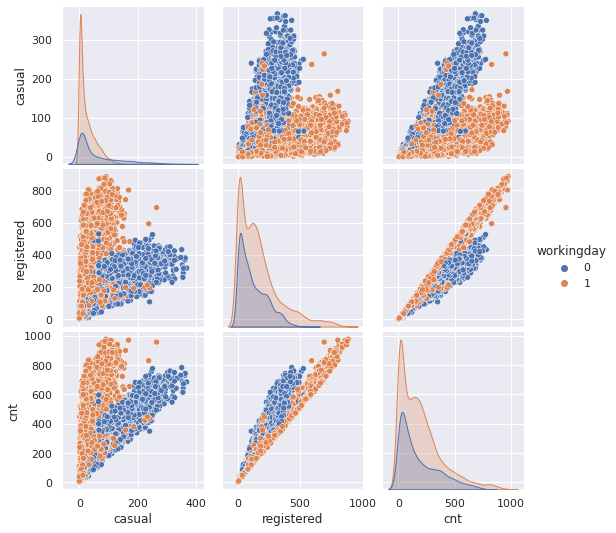

In [729]:
df_pp = df[['casual', 'registered', 'cnt','workingday']]
sns.pairplot(df_pp, hue='workingday');

In [730]:
(df['temp']-df['atemp']> 0.2).sum()


24

In [731]:
df = df[df['temp']-df['atemp']<= 0.2]


# **Choosing variables for the model:**

Obvious patterns relating to time variables can be seen - on an annual level and even on a weekly/daily level

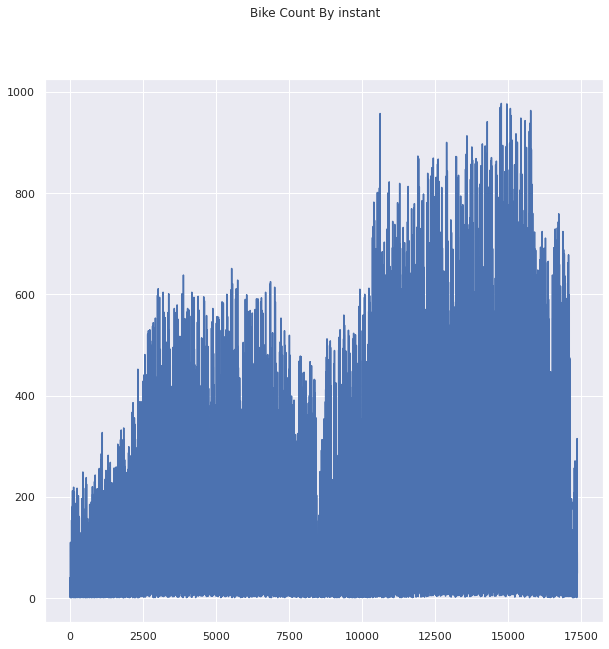

In [732]:
df.cnt.plot(figsize=(10,10))
pl.suptitle("Bike Count By instant");


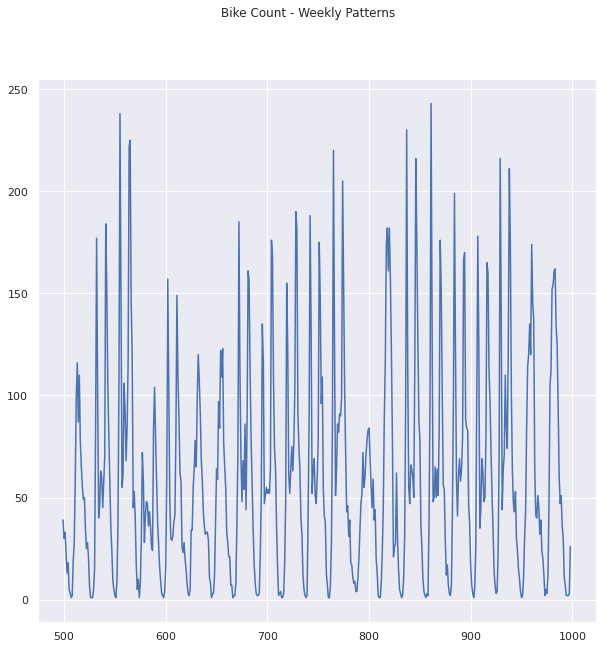

In [733]:
df.cnt.iloc[499:999].plot(figsize=(10,10))
pl.suptitle("Bike Count - Weekly Patterns");

We can create a new variable by using the existing weekday variable.
This variable will recode weekdays into two values - weekend and regular weekday

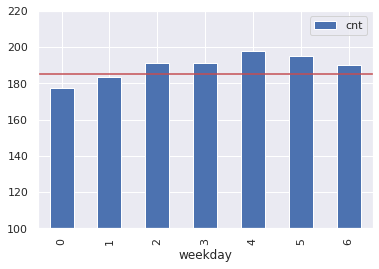

In [734]:
table = pd.pivot_table(df, values='cnt', index=['weekday'], aggfunc=np.mean)
table.plot(kind='bar',ylim=(100,220))
plt.axhline(y = 185, color = 'r', linestyle = '-')

In [735]:
df['weekend'] = np.where(df['weekday']<=1, 1, 0)

Season varaible also seems to affect bike counts. We will create summy variables for this categorical variable (same for weather situation)

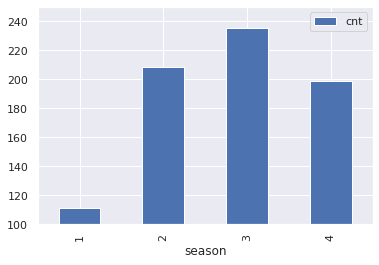

In [736]:
table = pd.pivot_table(df, values='cnt', index=['season'], aggfunc=np.mean)
table.plot(kind='bar',ylim=(100,250))


In [737]:
dummies = pd.get_dummies(data=df['season'],drop_first=True,prefix="season")
df = df.drop('season',axis = 1)
df = df.join(dummies)

In [738]:
dummies = pd.get_dummies(data=df['weathersit'],drop_first=True,prefix="weathersit")
df = df.drop('weathersit',axis = 1)
df = df.join(dummies)

The hours of the days will also be used to create a new variable - Day-time/Night-time

Text(0.5, 0.98, 'Hour to Binary - Day-time/Night-time')

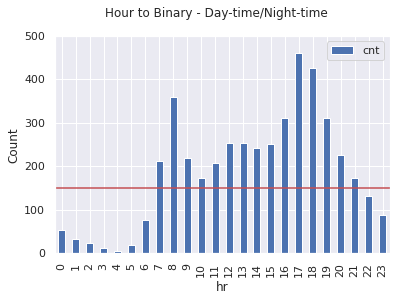

In [739]:
table = pd.pivot_table(df, values='cnt', index=['hr'], aggfunc=np.mean)
table.plot(kind='bar',ylim=(0,500), ylabel = 'Count')
plt.axhline(y = 150, color = 'r', linestyle = '-')
pl.suptitle("Hour to Binary - Day-time/Night-time")


In [740]:
df['daytime'] = np.where((df['hr']>=7) & (df['hr']<=21), 1, 0)

In [741]:
df.columns

Index(['instant', 'dteday', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt', 'weekend', 'season_2', 'season_3', 'season_4',
       'weathersit_2', 'weathersit_3', 'weathersit_4', 'daytime'],
      dtype='object')

In [742]:
df = df[['yr', 'daytime', 'workingday', 'temp', 'hum', 'windspeed',
         'season_2', 'season_3','season_4','weathersit_2', 'weathersit_3', 'weathersit_4',
         'casual', 'registered', 'cnt']]

**Correlation matrix for the variables:**

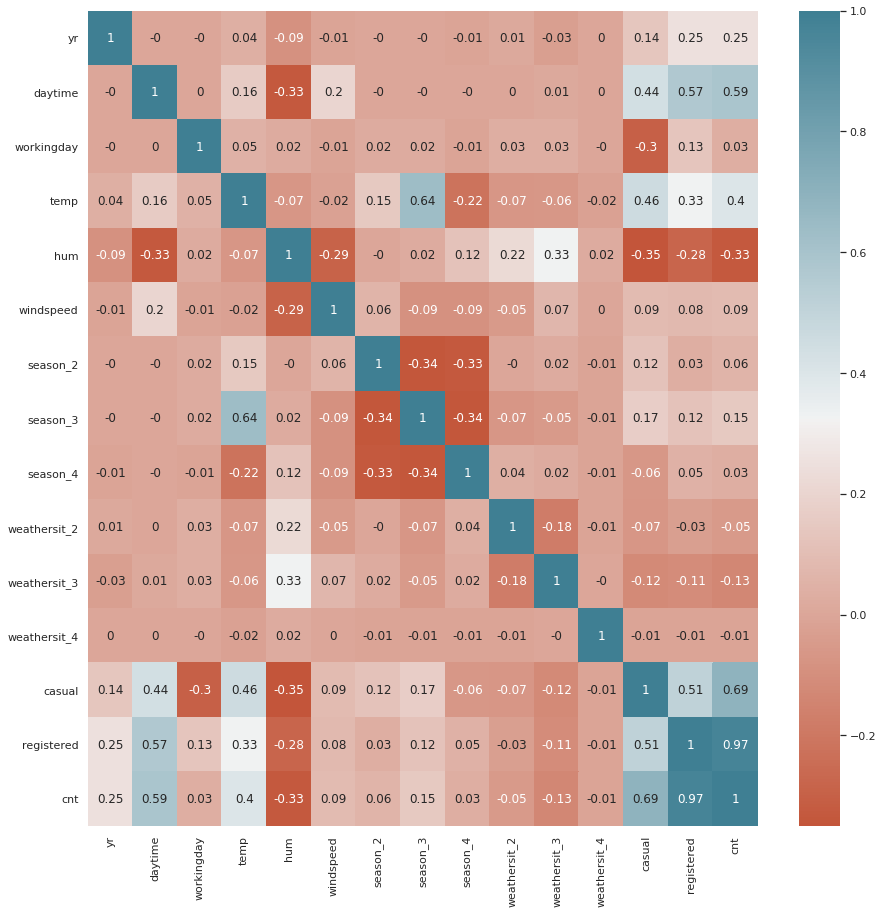

In [743]:
plt.figure(figsize=(15,15))
sns.set(font_scale=1) # Set font size
palette = sns.diverging_palette(20, 220, n=256)
sns.heatmap(data=round(df.corr(),2), cmap=palette, annot=True);

Training and testing the model:
All models will use the same train-test split (70%-30%)

In [744]:
df_train, df_test = split(df, train_size=0.7, random_state=123)

In [745]:
X_train = df_train.drop(['casual','registered','cnt'], axis=1)
y_train = df_train['cnt']

X_test = df_test.drop(['casual','registered','cnt'], axis=1)
y_test = df_test['cnt']

Scaling the explanatory variables:

In [746]:
scalar = StandardScaler()

# X_train_orig = X_train
# X_test_orig = X_test

X_train = pd.DataFrame(scalar.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(scalar.fit_transform(X_test),columns=X_test.columns)



In [747]:
X_test.describe()

,yr,daytime,workingday,temp,hum,windspeed,season_2,season_3,season_4,weathersit_2,weathersit_3,weathersit_4
count,5.200000e+03,5.200000e+03,5.200000e+03,5.200000e+03,5.200000e+03,5.200000e+03,5.200000e+03,5.200000e+03,5.200000e+03,5.200000e+03,5.200000e+03,5.200000e+03
mean,3.518553e-16,-1.109796e-16,1.468483e-16,-3.518175e-17,3.296508e-17,-9.223391e-18,3.335793e-16,-2.348549e-18,-8.834813e-17,-2.379293e-16,-9.159340e-17,1.277204e-15
std,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00
min,-1.011606e+00,-1.320630e+00,-1.455165e+00,-2.498553e+00,-2.555008e+00,-1.564267e+00,-5.957116e-01,-5.957116e-01,-5.640250e-01,-5.974895e-01,-3.021434e-01,-1.386884e-02
25%,-1.011606e+00,-1.320630e+00,-1.455165e+00,-8.329445e-01,-7.822149e-01,-7.059363e-01,-5.957116e-01,-5.957116e-01,-5.640250e-01,-5.974895e-01,-3.021434e-01,-1.386884e-02
50%,9.885273e-01,7.572144e-01,6.872072e-01,1.039604e-01,-1.002711e-04,2.918893e-02,-5.957116e-01,-5.957116e-01,-5.640250e-01,-5.974895e-01,-3.021434e-01,-1.386884e-02
75%,9.885273e-01,7.572144e-01,6.872072e-01,8.326642e-01,8.341553e-01,5.195462e-01,1.678665e+00,1.678665e+00,-5.640250e-01,1.673669e+00,-3.021434e-01,-1.386884e-02
max,9.885273e-01,7.572144e-01,6.872072e-01,2.602373e+00,1.929116e+00,5.300735e+00,1.678665e+00,1.678665e+00,1.772971e+00,1.673669e+00,3.309686e+00,7.210409e+01


Using a Lasso regression we can see if some variables should be removed from the model.
We can also choose the best hyperparameters using grid search

In [748]:
Lasso_gs = Lasso()
alpha  = np.arange(0.005,1,0.005)
lasso_params_ = { 'max_iter':[500],'alpha':alpha}
rmse_scorer = metrics.make_scorer(rmse, greater_is_better=False)
grid_lasso_m = GridSearchCV(Lasso_gs,
                          lasso_params_,
                          scoring = rmse_scorer,
                          cv=5)
grid_lasso_m.fit(X = X_train,y = y_train)
preds = grid_lasso_m.predict(X= X_test)
print (grid_lasso_m.best_params_)
print ("RMSE Value: ",rmse(y_test,preds))

{'alpha': 0.10500000000000001, 'max_iter': 500}
RMSE Value:  125.7519097591422


We decide not to remove any additional variable from the model:

In [749]:
pd.DataFrame({'param':X_train.columns, 'beta': Lasso(alpha=grid_lasso_m.best_params_['alpha']).fit(X_train,y_train).coef_})

,param,beta
0,yr,41.252063
1,daytime,93.797201
2,workingday,3.050862
3,temp,53.301139
4,hum,-18.849261
5,windspeed,-3.512324
6,season_2,15.320402
7,season_3,7.538220
8,season_4,27.737297
9,weathersit_2,-5.528619


In [750]:
X_train = df_train.drop(['casual','registered','cnt'], axis=1)
y_train = df_train['cnt']

X_test = df_test.drop(['casual','registered','cnt'], axis=1)
y_test = df_test['cnt']

# **Model 1 - Linear Regression:**

In [754]:
lm = LinearRegression()
lm.fit(X_train#_orig
       , y_train#_orig
       )
print("The model intercept is: {}".format(lm.intercept_))
print("The model coefficients are: {}".format(lm.coef_))

The model intercept is: -70.06953384649071
The model coefficients are: [ 82.72552349 194.09225517   6.79706416 274.83018787 -98.8866196
 -29.53985101  36.51631576  18.68169671  65.44226956 -12.82109649
 -52.10140138  22.90946249]


In [756]:
y_train_pred = lm.predict(X_train)
train_rmse_lm = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"RMSE (train lm) = {train_rmse_lm:.2f}")

y_test_pred = lm.predict(X_test)
test_rmse_lm = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"RMSE (test lm) = {test_rmse_lm:.2f}")

RMSE (train lm) = 121.37
RMSE (test lm) = 125.70


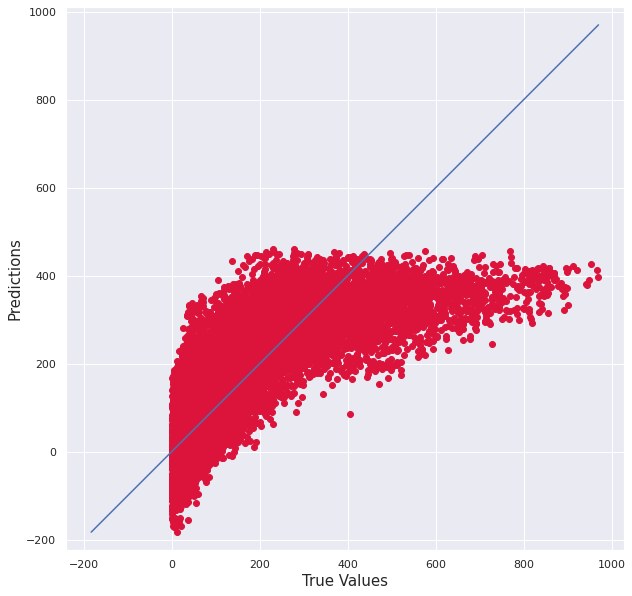

In [757]:
plt.figure(figsize=(10,10))
plt.scatter(y_train, y_train_pred, c='crimson')
p1 = max(max(y_train_pred), max(y_train))
p2 = min(min(y_train_pred), min(y_train))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

From the image above we can see that the linear model works well for mostly for the center of the data, and misses around extreme values.

In addition, a linear model produces negative results which are not desired for a count variable.

# **Model 2 - GLM - Poisson**

This model was chosen becuase it may be preferable to the linear model for a count variable

In [758]:
import statsmodels.api as sm
X_train2 = sm.add_constant(X_train)
glm_model = sm.GLM(y_train,X_train2,family = sm.families.Poisson(link=sm.families.links.log)).fit()
print(glm_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    cnt   No. Observations:                12133
Model:                            GLM   Df Residuals:                    12120
Model Family:                 Poisson   Df Model:                           12
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.9023e+05
Date:                Tue, 17 Aug 2021   Deviance:                   7.0309e+05
Time:                        22:48:26   Pearson chi2:                 7.27e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.9917      0.005    618.367   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [759]:
y_train_pred = glm_model.predict(X_train2)
train_rmse_glm = np.sqrt(mean_squared_error(y_train_orig, y_train_pred))
print(f"RMSE (train glm) = {train_rmse_glm:.2f}")

X_test2 = sm.add_constant(X_test)
y_test_pred = glm_model.predict(X_test2)
test_rmse_glm = np.sqrt(mean_squared_error(y_test_orig, y_test_pred))
print(f"RMSE (test glm) = {test_rmse_glm:.2f}")

RMSE (train glm) = 116.30
RMSE (test glm) = 121.73


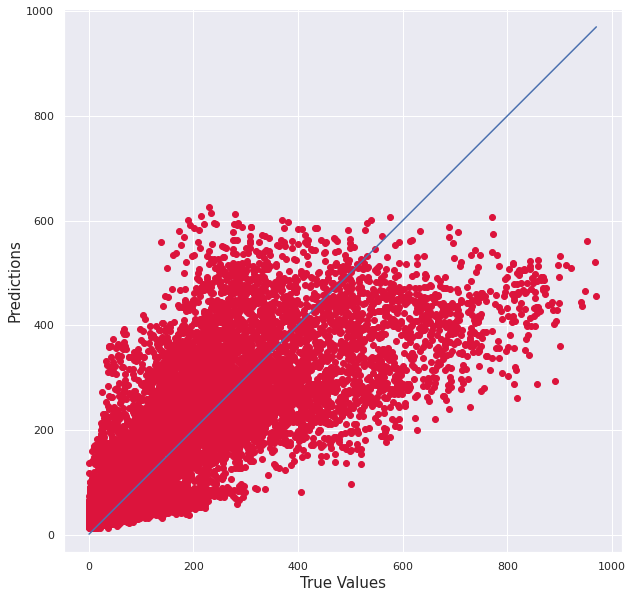

In [760]:
plt.figure(figsize=(10,10))
plt.scatter(y_train, y_train_pred, c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(y_train_pred), max(y_train))
p2 = min(min(y_train_pred), min(y_train))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

The image above shows that, while not perfect, the GLM does seem to better model the pattern of bike counts, in comparison to the linear model.

# **Model 3 - Decision Tree:**

- We will first remove the dummy variables from the model
- Then, choose the best hyper parameters for the decision tree 
- Lastly, run the model

In [761]:
X_train_tree = X_train.drop(['season_2','season_3', 'season_4', 'weathersit_2', 'weathersit_3', 'weathersit_4'], axis=1)
X_test_tree = X_test.drop(['season_2','season_3', 'season_4', 'weathersit_2', 'weathersit_3', 'weathersit_4'], axis=1)


In [762]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=0)
dt_params = {'max_leaf_nodes':np.arange(2,60,1)}

from sklearn.model_selection import GridSearchCV
gs_dt = GridSearchCV(dt,dt_params,cv=3)
gs_dt.fit(X_train_tree,y_train)
print("Best hyperparameter by gridsearch",gs_dt.best_params_)

Best hyperparameter by gridsearch {'max_leaf_nodes': 31}


In [763]:
tree_model = DecisionTreeRegressor(max_leaf_nodes=gs_dt.best_params_['max_leaf_nodes'])
tree_model.fit(X_train_tree,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=31,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Making sure that using 31 leaf nodes will not result in overfitting, by comparing the RMSE on train and test data, by increasing number of leaf nodes:

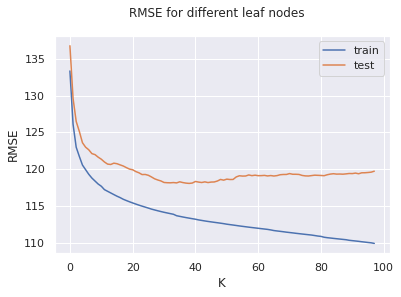

In [764]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

rmse_train_val = [] #to store rmse values for different k
rmse_test_val = [] #to store rmse values for different k
for K in range(2,100):
    K = K+1
    model = DecisionTreeRegressor(max_leaf_nodes=K)
    model.fit(X_train_tree, y_train)  #fit the model
    y_train_pred = model.predict(X_train_tree) #make prediction on test set
    y_test_pred = model.predict(X_test_tree) #make prediction on test set
    error_train = sqrt(mean_squared_error(y_train,y_train_pred))
    error_test = sqrt(mean_squared_error(y_test,y_test_pred)) #calculate rmse
    
    rmse_train_val.append(error_train) #store rmse values
    rmse_test_val.append(error_test) #store rmse values

curve_train = pd.DataFrame(rmse_train_val) #elbow curve 
curve_test = pd.DataFrame(rmse_test_val) #elbow curve 
plt.figure()

plt.plot(curve_train)
plt.plot(curve_test)

plt.legend(['train','test'])
plt.ylabel('RMSE')
plt.xlabel('K')
pl.suptitle("RMSE for different leaf nodes")
plt.show()


From the graph above we can indees see that the test RMSE begins to increase after approximately 31 nodes.

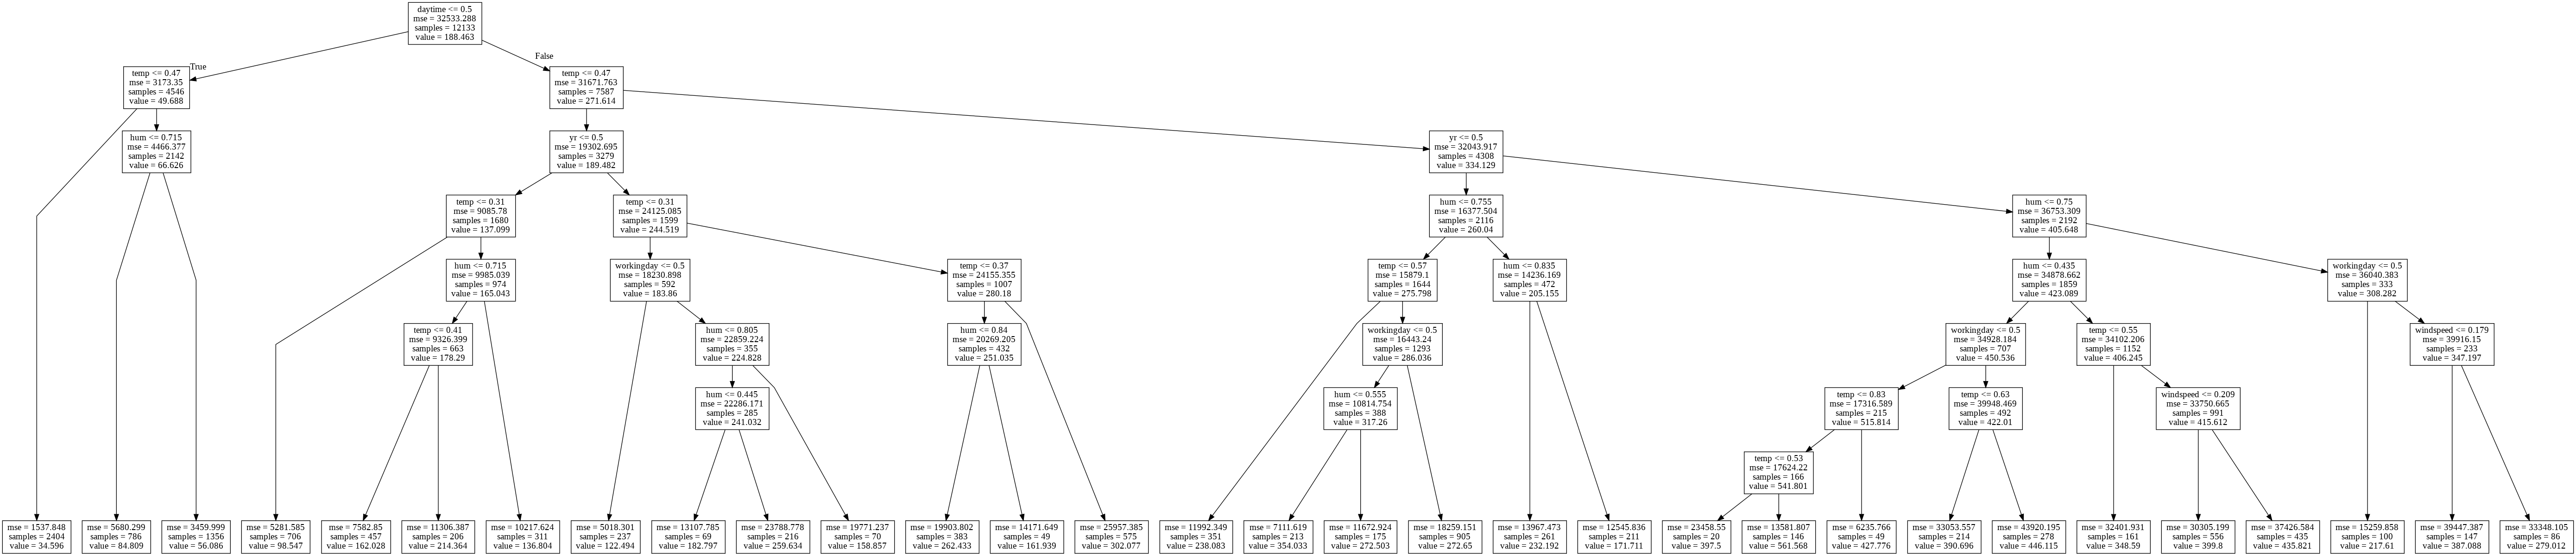

In [765]:
!pip install pydot
import pydot
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image

dot_data = StringIO()  
export_graphviz(tree_model, out_file=dot_data, feature_names=X_train_tree.columns, leaves_parallel=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
Image(graph.create_png(), width=10000) 

*pressing the above image will increase it

In [766]:
y_train_pred = tree_model.predict(X_train_tree)
train_rmse_tree = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"RMSE (train tree) = {train_rmse_tree:.2f}")

y_test_pred = tree_model.predict(X_test_tree)
test_rmse_tree = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"RMSE (test tree)= {test_rmse_tree:.2f}")

RMSE (train tree) = 114.32
RMSE (test tree)= 118.52


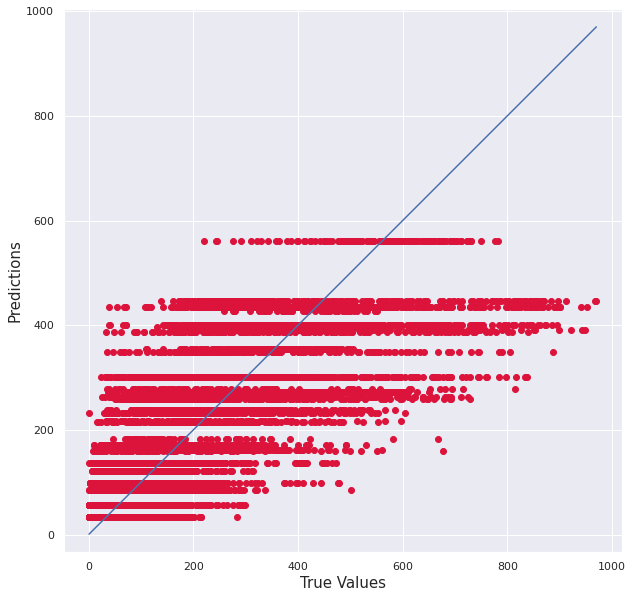

In [767]:
plt.figure(figsize=(10,10))
plt.scatter(y_train, y_train_pred, c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(y_train_pred), max(y_train))
p2 = min(min(y_train_pred), min(y_train))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

Though the decision tree only provides a limited amount of unique predicitions (according to the number of leaf nodes), it still produced a better prediction in terms of RMSE compared to the two previous models

# **Model 4 - KNN:**

Similarly to the tree, we will first choose the best hyperparameters and then run the model

In [768]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import pairwise_distances

knn = KNeighborsRegressor()
knn_params = {'n_neighbors':np.arange(2,15,1)}

from sklearn.model_selection import GridSearchCV
gs_knn = GridSearchCV(knn,knn_params,cv=3)
gs_knn.fit(X_train,y_train)
print("Best hyperparameter by gridsearch",gs_knn.best_params_)


Best hyperparameter by gridsearch {'n_neighbors': 14}


By plotting RMSE for an increasing number of neighbors, we can determine that 14 neighbors is a good choice, which will not result in overfitting, but still reduce errors.

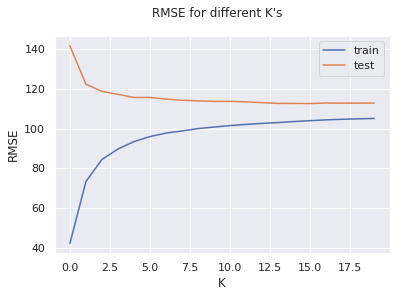

In [769]:
#import required packages
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

rmse_train_val = [] #to store rmse values for different k
rmse_test_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    y_train_pred = model.predict(X_train) #make prediction on test set
    y_test_pred = model.predict(X_test) #make prediction on test set
    error_train = sqrt(mean_squared_error(y_train,y_train_pred))
    error_test = sqrt(mean_squared_error(y_test,y_test_pred)) #calculate rmse
    
    rmse_train_val.append(error_train) #store rmse values
    rmse_test_val.append(error_test) #store rmse values

curve_train = pd.DataFrame(rmse_train_val) #elbow curve 
curve_test = pd.DataFrame(rmse_test_val) #elbow curve 

plt.figure()

plt.plot(curve_train)
plt.plot(curve_test)

plt.legend(['train','test'])

plt.ylabel('RMSE')
plt.xlabel('K')
pl.suptitle("RMSE for different K's")

plt.show()

In [770]:
KNN_model = KNeighborsRegressor(n_neighbors=gs_knn.best_params_['n_neighbors'])
KNN_model.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=14, p=2,
                    weights='uniform')

In [771]:
y_train_pred = KNN_model.predict(X_train)
train_rmse_knn = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"RMSE (train knn) = {train_rmse_knn:.2f}")

y_test_pred = KNN_model.predict(X_test)
test_rmse_knn = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"RMSE (test knn) = {test_rmse_knn:.2f}")

RMSE (train knn) = 103.05
RMSE (test knn) = 112.71


It appears that KNN produces the best results of all four models chosen.

970


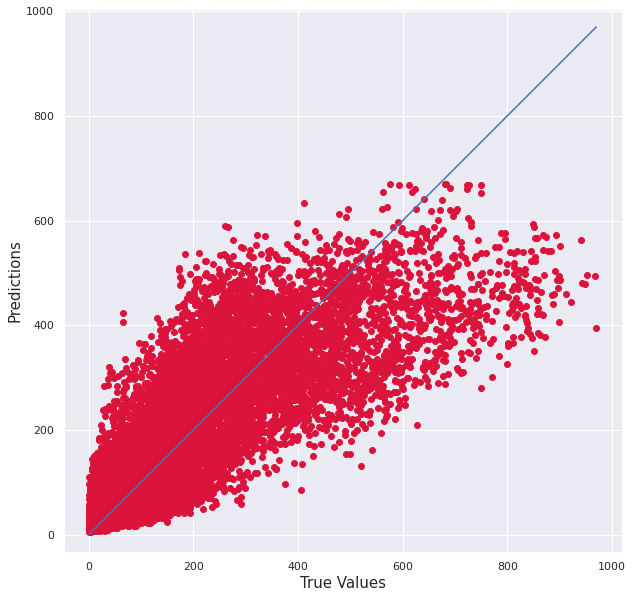

In [772]:
plt.figure(figsize=(10,10))
plt.scatter(df_train_orig['cnt'], y_train_pred, c='crimson')
# plt.yscale('log')
# plt.xscale('log')
print(max(y_train))
p1 = max(max(y_train_pred), max(df_train['cnt']))
p2 = min(min(y_train_pred), min(df_train['cnt']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()


# **Additional Model Improvements 1:**

By detecting a different pattern of bike rentals between "workingday"=0 and "workingday" = 1, we can try and model these patterns separately.

Below is an example for the linear regression, and as seen, the RMSE does improve by doing this.

Linear Regression - Separated by Workingday

In [784]:
df_train0 = df_train[df_train.workingday==0]
df_train1 = df_train[df_train.workingday==1]

df_test0 = df_test[df_test.workingday==0]
df_test1 = df_test[df_test.workingday==1]

X_train0 = df_train0.drop(['casual','registered','cnt'], axis=1)
y_train0 = df_train0['cnt']

X_train1 = df_train1.drop(['casual','registered','cnt'], axis=1)
y_train1 = df_train1['cnt']

X_test0 = df_test0.drop(['casual','registered','cnt'], axis=1)
y_test0 = df_test0['cnt']

X_test1 = df_test1.drop(['casual','registered','cnt'], axis=1)
y_test1 = df_test1['cnt']

lm0 = LinearRegression()
lm1 = LinearRegression()

lm0.fit(X_train0, y_train0)
lm1.fit(X_train1, y_train1)

y_train_pred0 = lm0.predict(X_train0)
y_train_pred1 = lm1.predict(X_train1)

train_mse0 = mean_squared_error(y_train0, y_train_pred0)
train_mse1 = mean_squared_error(y_train1, y_train_pred1)
train_rmse_lm2 = np.sqrt((train_mse0*len(y_train_pred0)+train_mse1*len(y_train_pred1))/(len(y_train_pred0)+len(y_train_pred1)))
print(f"RMSE = {train_rmse_lm2:.2f}")

y_test_pred0 = lm0.predict(X_test0)
y_test_pred1 = lm1.predict(X_test1)

test_mse0 = mean_squared_error(y_test0, y_test_pred0)
test_mse1 = mean_squared_error(y_test1, y_test_pred1)
test_rmse_lm2 = np.sqrt((test_mse0*len(y_test_pred0)+test_mse1*len(y_test_pred1))/(len(y_test_pred0)+len(y_test_pred1)))
print(f"RMSE = {test_rmse_lm2:.2f}")

RMSE = 119.15
RMSE = 123.40


# **Additional Model Improvements 2:**

By recognizing that casual users and registered users have different patterns (can be seen both from the pair plot and from the correlation matrix), we can model each separately - and sum them together to create the final model, below is an example for GLM


In [793]:
glm_model1 = sm.GLM(y_train1,X_train2,family = sm.families.Poisson(link=sm.families.links.log)).fit()

y_train_pred1 = glm_model1.predict(X_train2)
y_test_pred1 = glm_model1.predict(X_test2)

glm_model2 = sm.GLM(y_train2,X_train2,family = sm.families.Poisson(link=sm.families.links.log)).fit()

y_train_pred2 = glm_model2.predict(X_train2)
y_test_pred2 = glm_model2.predict(X_test2)


train_rmse_glm2 = np.sqrt(mean_squared_error(y_train, y_train_pred1 + y_train_pred2))
print(f"RMSE (train) = {train_rmse_glm2:.2f}")
test_rmse_glm2 = np.sqrt(mean_squared_error(y_test, y_test_pred1 + y_test_pred2))
print(f"RMSE (test) = {test_rmse_glm2:.2f}",end='\n')

print(glm_model1.summary(),end='\n\n\n')
print(glm_model2.summary())

RMSE (train) = 115.65
RMSE (test) = 121.30
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 casual   No. Observations:                12133
Model:                            GLM   Df Residuals:                    12120
Model Family:                 Poisson   Df Model:                           12
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0736e+05
Date:                Tue, 17 Aug 2021   Deviance:                   1.6287e+05
Time:                        23:15:37   Pearson chi2:                 1.76e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  


# **Summary:**
Below is a table containing all RMSE values calculated during this process:

In [798]:
data = {'Method': ['Multiple Linear Model', 'GLM', 'Decision Tree', 'KNN', 'Linear Model Improvement (by working day separation)', 
                   'GLM Improvement (by modeling casual and registered users separately)'], 
        'RMSE Train': [train_rmse_lm, train_rmse_glm, train_rmse_tree, train_rmse_knn,train_rmse_lm2,train_rmse_glm2],
        'RMSE Test': [test_rmse_lm, test_rmse_glm, test_rmse_tree, test_rmse_knn,test_rmse_lm2,test_rmse_glm2]}
pd.DataFrame(data)

,Method,RMSE Train,RMSE Test
0,Multiple Linear Model,121.365013,125.696644
1,GLM,116.303848,121.726342
2,Decision Tree,114.324091,118.515043
3,KNN,103.047238,112.711393
4,Linear Model Improvement (by working day separ...,121.365013,125.696644
5,GLM Improvement (by modeling casual and regist...,115.647245,121.301979


# **Conclusions:**
- Knn achieved the best results out of all 4 types of models chosen.
- None of the models was able to reach a very low error (even KNN has an error of 100 bikes).
- Models can be further improved by modeling casual and registered users separately and also creating separate model by working day.
- The model does seem to be very time dependent - perhaps a model such as time series could be better suited for such a problem